# Assignment 3 — Part 2: Train Segmentation Head

Abhinav Kumar
11/2/2025

In [ ]:
import itertools, random
from datasets import load_dataset
from PIL import Image

N_SAMPLES = 256
ds_stream = load_dataset("harpreetsahota/CarDD", streaming=True)
key = "train" if "train" in ds_stream else list(ds_stream.keys())[0]
records = []
for ex in itertools.islice(iter(ds_stream[key]), N_SAMPLES):
    img = ex["image"]
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    records.append({"image": img})

import math, os, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import timm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import contextlib
use_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler("cuda") if use_amp else None
amp_ctx = torch.amp.autocast("cuda") if use_amp else contextlib.nullcontext()

torch.set_num_threads(1)

IMG_SIZE = 224
BATCH_SIZE = 2
EPOCHS = 100
LR = 3e-4

data = records

from PIL import Image

def make_mask(pil_image):
    w, h = pil_image.size
    m = np.zeros((h, w), dtype=np.uint8)
    rw, rh = max(8, w//10), max(8, h//10)
    x1, y1 = (w - rw)//2, (h - rh)//2
    m[y1:y1+rh, x1:x1+rw] = 1
    return Image.fromarray(m*255)


t_img = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])
t_mask = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.NEAREST),
                    T.ToTensor()])

def to_rgb(pil):
    return pil if pil.mode == "RGB" else pil.convert("RGB")

class SegHF(Dataset):
    def __init__(self, records):
        self.records = records
    def __len__(self): 
        return len(self.records)
    def __getitem__(self, idx):
        img = to_rgb(self.records[idx]["image"])
        mask = make_mask(img)
        x = t_img(img)
        y = (t_mask(mask) > 0.5).float()
        return x.clone(), y.clone()

n = len(data)
idxs = list(range(n)); random.shuffle(idxs)
vsize = max(1, int(0.2*n))
val_set = set(idxs[:vsize])
train_ds = SegHF([data[i] for i in range(n) if i not in val_set])
val_ds   = SegHF([data[i] for i in range(n) if i in val_set])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)


def make_backbone(name=None):
    m = timm.create_model("resnet50", features_only=True, pretrained=True)
    ch = m.feature_info.channels()
    return m, ch


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_c, out_c, k=3, s=1, p=1):
        super().__init__(nn.Conv2d(in_c, out_c, k, s, p, bias=False),
                         nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))

class FPNDecoder(nn.Module):
    def __init__(self, feat_channels, out_ch=128):
        super().__init__()
        self.lat = nn.ModuleList([nn.Conv2d(c, out_ch, 1) for c in feat_channels])
        self.smooth = nn.ModuleList([ConvBNReLU(out_ch, out_ch) for _ in feat_channels])

    def forward(self, feats):
        feats = feats[-len(self.lat):]
        x = None
        outs = []
        for i in reversed(range(len(feats))):
            f = self.lat[i](feats[i])
            if x is None:
                x = f
            else:
                x = f + F.interpolate(x, size=f.shape[-2:], mode="bilinear", align_corners=False)
            x = self.smooth[i](x)
            outs.append(x)
        outs = list(reversed(outs))
        size = outs[0].shape[-2:]
        up = [F.interpolate(o, size, mode='bilinear', align_corners=False) for o in outs]
        return torch.cat(up, dim=1)


class SegModel(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        self.backbone, ch = make_backbone()    
        ch_used = ch[-4:]                    
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        self.decoder = FPNDecoder(ch_used)
        self.head = nn.Sequential(
            ConvBNReLU(128 * len(ch_used), 256),
            ConvBNReLU(256, 128),
            nn.Conv2d(128, 1, 1),
        )

    def forward(self, x):
        feats = self.backbone(x)
        dec = self.decoder(feats)
        logit = self.head(dec)
        return F.interpolate(logit, size=x.shape[-2:], mode="bilinear", align_corners=False)

def dice_loss(logit, target, eps=1e-6):
    p = torch.sigmoid(logit)
    num = 2*(p*target).sum(dim=(2,3))+eps
    den = (p+target).sum(dim=(2,3))+eps
    return (1 - num/den).mean()

def bce_loss(logit, target):
    return F.binary_cross_entropy_with_logits(logit, target)

def iou_metric(logit, target, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logit)>thr).float()
    inter = (p*target).sum(dim=(2,3))
    union = (p+target - p*target).sum(dim=(2,3))+eps
    return (inter/union).mean().item()

model = SegModel(freeze_backbone=True).to(device)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

hist = {"loss":[], "val_iou":[], "val_dice":[]}
for epoch in range(1, EPOCHS+1):
    model.train(); running=0.0
    for img, mask in tqdm(train_loader, desc=f"Epoch {epoch}"):
        img, mask = img.to(device), mask.to(device)
        opt.zero_grad(set_to_none=True)
        with amp_ctx:
            logit = model(img)
            loss = 0.7*dice_loss(logit, mask) + 0.3*bce_loss(logit, mask)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
        else:
            loss.backward()
            opt.step()
        running += loss.item()*img.size(0)
    epoch_loss = running/len(train_loader.dataset)

    model.eval(); ious=[]; dices=[]
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            logit = model(img)
            ious.append(iou_metric(logit, mask))
            p = (torch.sigmoid(logit)>0.5).float()
            inter = (p*mask).sum(dim=(2,3))*2
            denom = p.sum(dim=(2,3)) + mask.sum(dim=(2,3)) + 1e-6
            dices.append((inter/denom).mean().item())
    hist["loss"].append(epoch_loss); hist["val_iou"].append(float(np.mean(ious))); hist["val_dice"].append(float(np.mean(dices)))
    print(f"Epoch {epoch}: loss={epoch_loss:.4f} | IoU={hist['val_iou'][-1]:.4f} | Dice={hist['val_dice'][-1]:.4f}")


HTTP Error 503 thrown while requesting GET https://huggingface.co/datasets/harpreetsahota/CarDD/resolve/56900bde8dddfe00eb7c03114a1d46e9105e3cdb/data/000196.jpg
Retrying in 1s [Retry 1/5].
HTTP Error 503 thrown while requesting GET https://huggingface.co/datasets/harpreetsahota/CarDD/resolve/56900bde8dddfe00eb7c03114a1d46e9105e3cdb/data/000196.jpg
Retrying in 2s [Retry 2/5].


Device: cpu


/tmp/ipykernel_7712/3268418237.py:152: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
Epoch 1: 100%|██████████| 103/103 [02:03<00:00,  1.20s/it]


Epoch 1: loss=0.7692 | IoU=0.0649 | Dice=0.1146


Epoch 2: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 2: loss=0.6548 | IoU=0.0927 | Dice=0.1538


Epoch 3: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 3: loss=0.5644 | IoU=0.0879 | Dice=0.1547


Epoch 4: 100%|██████████| 103/103 [01:56<00:00,  1.13s/it]


Epoch 4: loss=0.4835 | IoU=0.1026 | Dice=0.1751


Epoch 5: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 5: loss=0.4178 | IoU=0.1189 | Dice=0.1837


Epoch 6: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 6: loss=0.3800 | IoU=0.1174 | Dice=0.1820


Epoch 7: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 7: loss=0.3243 | IoU=0.1297 | Dice=0.1947


Epoch 8: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 8: loss=0.2914 | IoU=0.0987 | Dice=0.1460


Epoch 9: 100%|██████████| 103/103 [01:57<00:00,  1.15s/it]


Epoch 9: loss=0.2689 | IoU=0.1307 | Dice=0.1997


Epoch 10: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 10: loss=0.2426 | IoU=0.0537 | Dice=0.0789


Epoch 11: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 11: loss=0.2320 | IoU=0.1178 | Dice=0.1777


Epoch 12: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 12: loss=0.2066 | IoU=0.1083 | Dice=0.1598


Epoch 13: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 13: loss=0.1814 | IoU=0.1802 | Dice=0.2569


Epoch 14: 100%|██████████| 103/103 [01:56<00:00,  1.14s/it]


Epoch 14: loss=0.1811 | IoU=0.1390 | Dice=0.2076


Epoch 15: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 15: loss=0.1655 | IoU=0.1074 | Dice=0.1554


Epoch 16: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 16: loss=0.1543 | IoU=0.1449 | Dice=0.2115


Epoch 17: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 17: loss=0.1414 | IoU=0.1338 | Dice=0.1985


Epoch 18: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 18: loss=0.1330 | IoU=0.1244 | Dice=0.1814


Epoch 19: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 19: loss=0.1162 | IoU=0.1053 | Dice=0.1535


Epoch 20: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 20: loss=0.1028 | IoU=0.1213 | Dice=0.1656


Epoch 21: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 21: loss=0.0862 | IoU=0.1025 | Dice=0.1487


Epoch 22: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 22: loss=0.0748 | IoU=0.1201 | Dice=0.1666


Epoch 23: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 23: loss=0.0561 | IoU=0.0483 | Dice=0.0774


Epoch 24: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 24: loss=0.0626 | IoU=0.1373 | Dice=0.1982


Epoch 25: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 25: loss=0.0442 | IoU=0.0874 | Dice=0.1275


Epoch 26: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 26: loss=0.0420 | IoU=0.0889 | Dice=0.1208


Epoch 27: 100%|██████████| 103/103 [01:57<00:00,  1.15s/it]


Epoch 27: loss=0.0276 | IoU=0.1506 | Dice=0.2084


Epoch 28: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 28: loss=0.0256 | IoU=0.1529 | Dice=0.2097


Epoch 29: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 29: loss=0.0241 | IoU=0.1559 | Dice=0.2153


Epoch 30: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 30: loss=0.0231 | IoU=0.1139 | Dice=0.1535


Epoch 31: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 31: loss=0.0139 | IoU=0.0979 | Dice=0.1371


Epoch 32: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 32: loss=0.0086 | IoU=0.0711 | Dice=0.0921


Epoch 33: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 33: loss=0.0167 | IoU=0.0875 | Dice=0.1176


Epoch 34: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 34: loss=0.0115 | IoU=0.1009 | Dice=0.1409


Epoch 35: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 35: loss=0.0089 | IoU=0.1954 | Dice=0.2609


Epoch 36: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 36: loss=0.0098 | IoU=0.0488 | Dice=0.0704


Epoch 37: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 37: loss=0.0059 | IoU=0.1146 | Dice=0.1473


Epoch 38: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 38: loss=0.0051 | IoU=0.0737 | Dice=0.0941


Epoch 39: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 39: loss=0.0080 | IoU=0.1686 | Dice=0.2587


Epoch 40: 100%|██████████| 103/103 [02:05<00:00,  1.22s/it]


Epoch 40: loss=0.0180 | IoU=0.0777 | Dice=0.1138


Epoch 41: 100%|██████████| 103/103 [01:57<00:00,  1.15s/it]


Epoch 41: loss=0.0185 | IoU=0.1534 | Dice=0.2147


Epoch 42: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 42: loss=0.0103 | IoU=0.0829 | Dice=0.1192


Epoch 43: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 43: loss=0.0125 | IoU=0.2381 | Dice=0.3168


Epoch 44: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 44: loss=0.0112 | IoU=0.1243 | Dice=0.1671


Epoch 45: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 45: loss=0.0120 | IoU=0.1914 | Dice=0.2467


Epoch 46: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 46: loss=0.0122 | IoU=0.1574 | Dice=0.2019


Epoch 47: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 47: loss=0.0097 | IoU=0.0410 | Dice=0.0588


Epoch 48: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 48: loss=0.0129 | IoU=0.1279 | Dice=0.1730


Epoch 49: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 49: loss=0.0296 | IoU=0.0882 | Dice=0.1157


Epoch 50: 100%|██████████| 103/103 [01:57<00:00,  1.15s/it]


Epoch 50: loss=0.0144 | IoU=0.0933 | Dice=0.1286


Epoch 51: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 51: loss=0.0102 | IoU=0.1088 | Dice=0.1403


Epoch 52: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 52: loss=0.0095 | IoU=0.1041 | Dice=0.1343


Epoch 53: 100%|██████████| 103/103 [01:57<00:00,  1.15s/it]


Epoch 53: loss=0.0039 | IoU=0.1007 | Dice=0.1358


Epoch 54: 100%|██████████| 103/103 [01:59<00:00,  1.16s/it]


Epoch 54: loss=0.0050 | IoU=0.1598 | Dice=0.1979


Epoch 55: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 55: loss=0.0082 | IoU=0.1318 | Dice=0.1711


Epoch 56: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 56: loss=0.0078 | IoU=0.1118 | Dice=0.1601


Epoch 57: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 57: loss=0.0045 | IoU=0.0420 | Dice=0.0581


Epoch 58: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 58: loss=0.0063 | IoU=0.0910 | Dice=0.1351


Epoch 59: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 59: loss=0.0219 | IoU=0.1186 | Dice=0.1661


Epoch 60: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 60: loss=0.0297 | IoU=0.1579 | Dice=0.2252


Epoch 61: 100%|██████████| 103/103 [02:05<00:00,  1.22s/it]


Epoch 61: loss=0.0202 | IoU=0.0447 | Dice=0.0555


Epoch 62: 100%|██████████| 103/103 [02:02<00:00,  1.19s/it]


Epoch 62: loss=0.0146 | IoU=0.0689 | Dice=0.0899


Epoch 63: 100%|██████████| 103/103 [02:01<00:00,  1.18s/it]


Epoch 63: loss=0.0151 | IoU=0.1585 | Dice=0.2234


Epoch 64: 100%|██████████| 103/103 [02:01<00:00,  1.18s/it]


Epoch 64: loss=0.0105 | IoU=0.0891 | Dice=0.1167


Epoch 65: 100%|██████████| 103/103 [02:01<00:00,  1.18s/it]


Epoch 65: loss=0.0045 | IoU=0.0796 | Dice=0.1114


Epoch 66: 100%|██████████| 103/103 [02:00<00:00,  1.17s/it]


Epoch 66: loss=0.0048 | IoU=0.0663 | Dice=0.1000


Epoch 67: 100%|██████████| 103/103 [01:59<00:00,  1.16s/it]


Epoch 67: loss=0.0083 | IoU=0.0995 | Dice=0.1289


Epoch 68: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 68: loss=0.0060 | IoU=0.0784 | Dice=0.0975


Epoch 69: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 69: loss=0.0031 | IoU=0.0698 | Dice=0.1057


Epoch 70: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 70: loss=0.0051 | IoU=0.1506 | Dice=0.2038


Epoch 71: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 71: loss=0.0093 | IoU=0.0604 | Dice=0.0871


Epoch 72: 100%|██████████| 103/103 [02:00<00:00,  1.17s/it]


Epoch 72: loss=0.0059 | IoU=0.0790 | Dice=0.1083


Epoch 73: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 73: loss=0.0053 | IoU=0.0557 | Dice=0.0812


Epoch 74: 100%|██████████| 103/103 [01:58<00:00,  1.15s/it]


Epoch 74: loss=0.0033 | IoU=0.1000 | Dice=0.1406


Epoch 75: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 75: loss=0.0042 | IoU=0.0903 | Dice=0.1187


Epoch 76: 100%|██████████| 103/103 [01:57<00:00,  1.14s/it]


Epoch 76: loss=0.0043 | IoU=0.1170 | Dice=0.1563


Epoch 77: 100%|██████████| 103/103 [02:06<00:00,  1.23s/it]


Epoch 77: loss=0.0054 | IoU=0.0953 | Dice=0.1298


Epoch 78: 100%|██████████| 103/103 [02:03<00:00,  1.20s/it]


Epoch 78: loss=0.0040 | IoU=0.0810 | Dice=0.1029


Epoch 79: 100%|██████████| 103/103 [02:03<00:00,  1.20s/it]


Epoch 79: loss=0.0162 | IoU=0.0591 | Dice=0.0782


Epoch 80: 100%|██████████| 103/103 [02:04<00:00,  1.21s/it]


Epoch 80: loss=0.0094 | IoU=0.1049 | Dice=0.1368


Epoch 81: 100%|██████████| 103/103 [02:07<00:00,  1.24s/it]


Epoch 81: loss=0.0028 | IoU=0.0894 | Dice=0.1243


Epoch 82: 100%|██████████| 103/103 [02:07<00:00,  1.24s/it]


Epoch 82: loss=0.0040 | IoU=0.2080 | Dice=0.2744


Epoch 83:  82%|████████▏ | 84/103 [01:42<00:25,  1.36s/it]

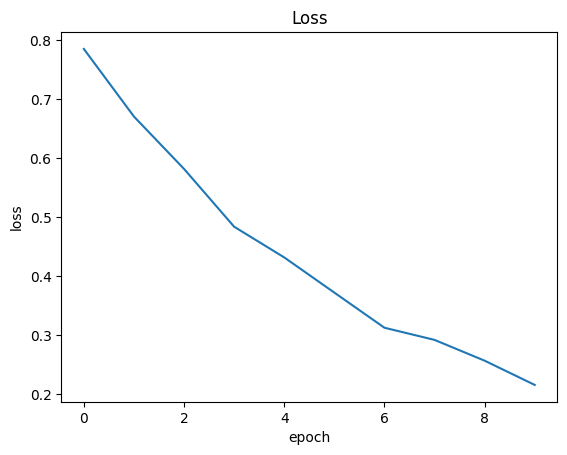

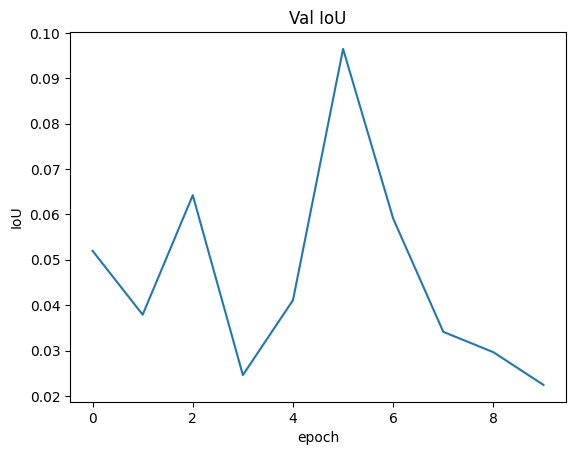

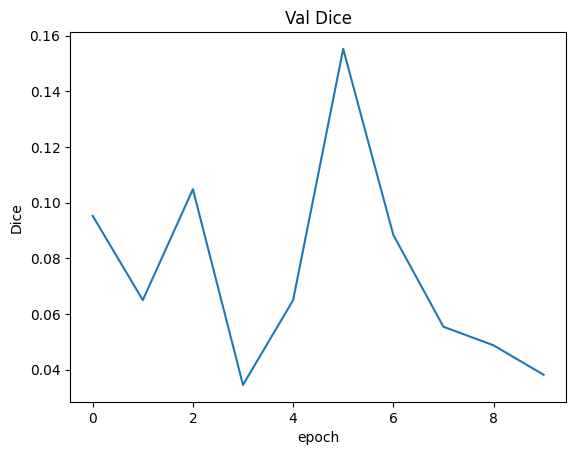

In [9]:
import matplotlib.pyplot as plt
plt.figure(); plt.plot(hist["loss"]); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()
plt.figure(); plt.plot(hist["val_iou"]); plt.title("Val IoU"); plt.xlabel("epoch"); plt.ylabel("IoU"); plt.show()
plt.figure(); plt.plot(hist["val_dice"]); plt.title("Val Dice"); plt.xlabel("epoch"); plt.ylabel("Dice"); plt.show()